In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torch.nn.functional import normalize
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [3]:
# Transformations for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter for airplane (class 0) and automobile (class 1)
class_indices = [0, 1]
filtered_indices = [i for i, (_, label) in enumerate(cifar10) if label in class_indices]
filtered_dataset = Subset(cifar10, filtered_indices)

# Split filtered dataset into train and validation sets
train_size = int(0.8 * len(filtered_dataset))  # 80% for training
val_size = len(filtered_dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(filtered_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Load CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
filtered_test_indices = [i for i, (_, label) in enumerate(test_dataset) if label in class_indices]
filtered_test_dataset = Subset(test_dataset, filtered_test_indices)
test_loader = DataLoader(filtered_test_dataset, batch_size=64, shuffle=False)

# Print sizes to verify
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(filtered_test_dataset)}")


100%|██████████| 170498071/170498071 [00:05<00:00, 28954221.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train dataset size: 8000
Validation dataset size: 2000
Test dataset size: 2000


**Part 1.**

Download CIFAR-10 and define pre-trained classifier 

*Part 1.a*

In [3]:
# Load pre-trained ResNet-50
resnet50 = models.resnet50(pretrained=True)

# Modify the last layer for binary classification
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)

# Send model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s] 


*Part 1.b* 

Train the model

In [13]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=20, best_model_name="best_model"):
    """
    Trains the model and evaluates it on validation data. Saves the model with the best validation accuracy.

    Args:
        model: The neural network model.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer.
        device: Device to run the training on (CPU/GPU).
        epochs: Number of epochs to train.

    Returns:
        metrics: Dictionary containing training and validation metrics:
                 - train_losses: List of training losses per epoch.
                 - train_accuracies: List of training accuracies per epoch.
                 - val_losses: List of validation losses per epoch.
                 - val_accuracies: List of validation accuracies per epoch.
        best_model: The model with the highest validation accuracy.
    """
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Record training metrics
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Record validation metrics
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save the model if validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()  # Save model state
            print(f"Best model updated at epoch {epoch+1} with validation accuracy: {val_accuracy:.2f}%")

    # Load the best model state into the model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Return all metrics and the best model
    metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies
    }
    torch.save(best_model_state, best_model_name+".pth")
    return metrics, model



def test(model, test_loader, device):
    """
    Tests the model and calculates accuracy.
    
    Args:
        model: The neural network model.
        test_loader: DataLoader for test data.
        device: Device to run the testing on (CPU/GPU).
    
    Returns:
        test_accuracy: Accuracy on the test dataset.
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


*Part 1.c*

Plot accuracy and loss

Epoch 1/10, Training Loss: 0.2206, Training Accuracy: 91.76%
Validation Loss: 0.1070, Validation Accuracy: 95.85%
Best model updated at epoch 1 with validation accuracy: 95.85%
Epoch 2/10, Training Loss: 0.1093, Training Accuracy: 96.17%
Validation Loss: 0.1128, Validation Accuracy: 96.25%
Best model updated at epoch 2 with validation accuracy: 96.25%
Epoch 3/10, Training Loss: 0.1259, Training Accuracy: 95.31%
Validation Loss: 0.0974, Validation Accuracy: 96.25%
Epoch 4/10, Training Loss: 0.0863, Training Accuracy: 97.03%
Validation Loss: 0.1098, Validation Accuracy: 95.55%
Epoch 5/10, Training Loss: 0.0489, Training Accuracy: 98.36%
Validation Loss: 0.0853, Validation Accuracy: 96.30%
Best model updated at epoch 5 with validation accuracy: 96.30%
Epoch 6/10, Training Loss: 0.0241, Training Accuracy: 99.04%
Validation Loss: 0.0851, Validation Accuracy: 97.30%
Best model updated at epoch 6 with validation accuracy: 97.30%
Epoch 7/10, Training Loss: 0.0285, Training Accuracy: 98.95%
Val

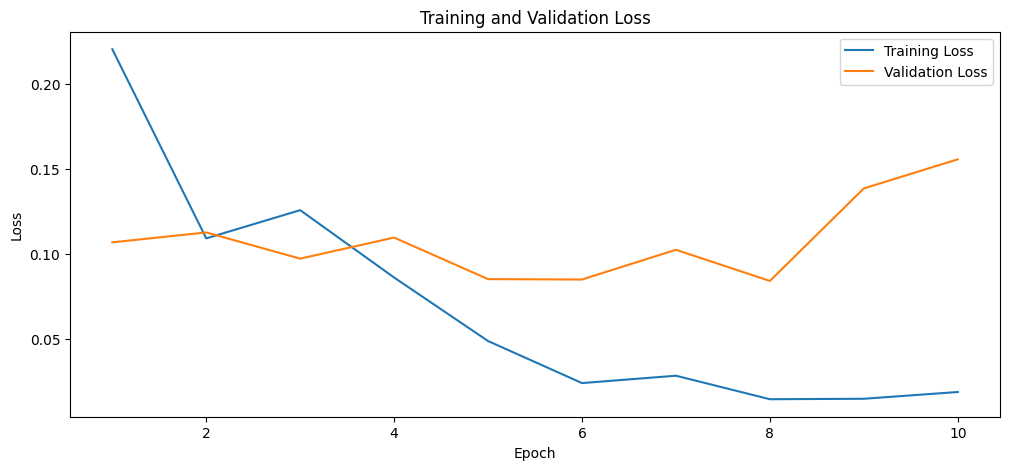

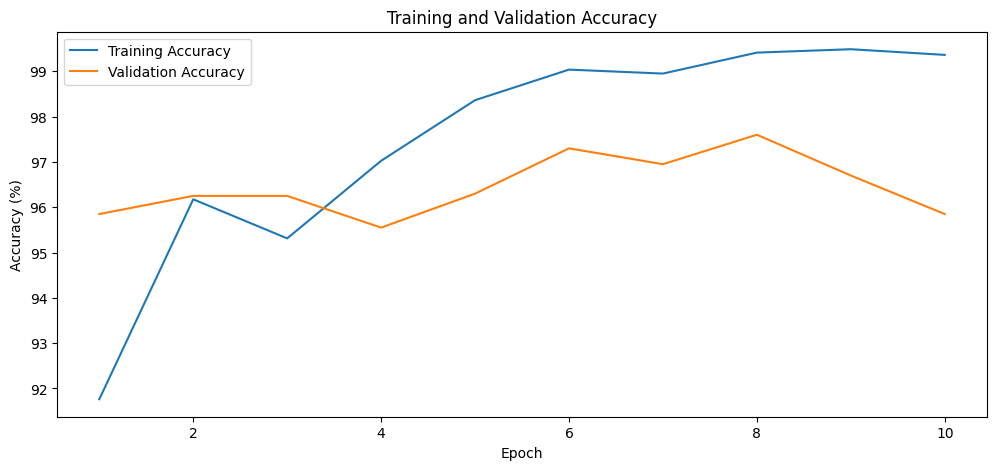

Test Accuracy: 96.40%
Final Test Accuracy of Best Model: 96.40%


In [5]:
# Train the model
metrics, best_model = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

# Extract metrics for plotting
train_losses = metrics["train_losses"]
train_accuracies = metrics["train_accuracies"]
val_losses = metrics["val_losses"]
val_accuracies = metrics["val_accuracies"]

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(1, 11), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 11), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Test the best model
test_accuracy = test(best_model, test_loader, device)
print(f"Final Test Accuracy of Best Model: {test_accuracy:.2f}%")


*Part 1.d*

Visualizing feature map

In [18]:
def visualize_feature_maps(model, layer_names, input_image):
    """
    Extracts and visualizes feature maps from specified layers.

    Args:
        model: The trained model.
        layer_names: List of layer names to extract feature maps from.
        input_image: A single input image tensor.
    """
    # Dictionary to store the feature maps
    feature_maps = {}
    input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension

    # Hook function to capture the feature maps
    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.cpu().detach()
        return hook

    # Register hooks for specified layers
    hooks = []
    for name, module in model.named_modules():
        if name in layer_names:
            hooks.append(module.register_forward_hook(hook_fn(name)))

    # Perform a forward pass to collect feature maps
    model.eval()
    with torch.no_grad():
        model(input_image)

    # Remove hooks to prevent memory leaks
    for hook in hooks:
        hook.remove()

    # Visualize feature maps for each layer
    for layer_name, fmap in feature_maps.items():
        num_filters = fmap.shape[1]  # Number of feature maps
        grid_size = int(np.ceil(np.sqrt(min(num_filters, 16))))  # Grid size for visualization
        fmap = fmap.squeeze(0)  # Remove batch dimension

        # Plot the feature maps
        plt.figure(figsize=(12, 12))
        plt.suptitle(f"Feature Maps from {layer_name}", fontsize=16)
        for i in range(min(num_filters, 16)):  # Visualize up to 16 feature maps
            plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(fmap[i], cmap='viridis')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

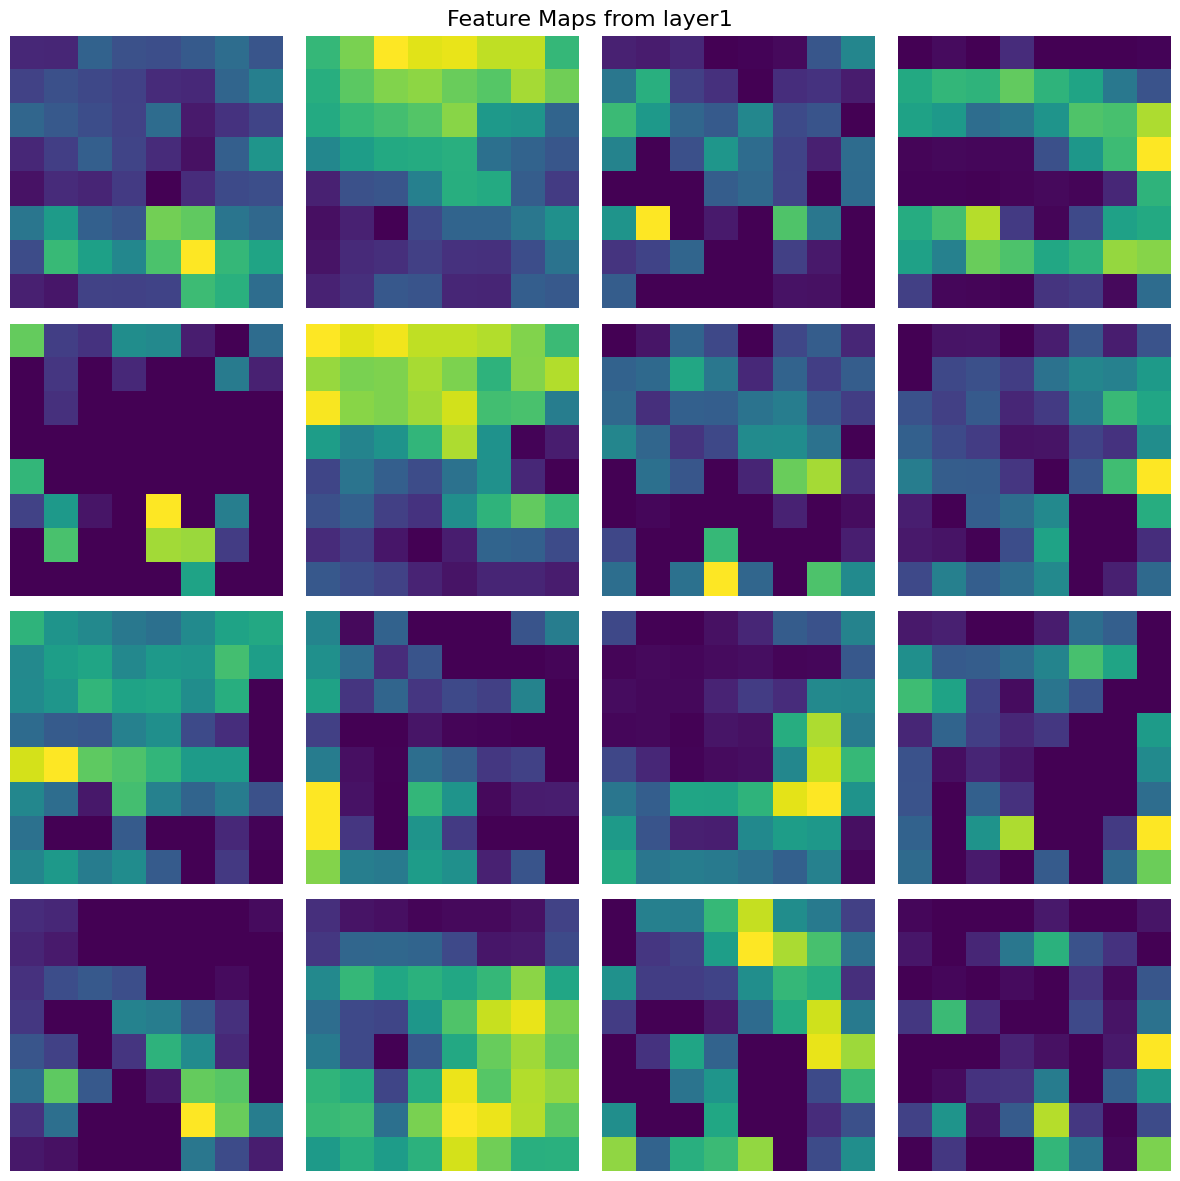

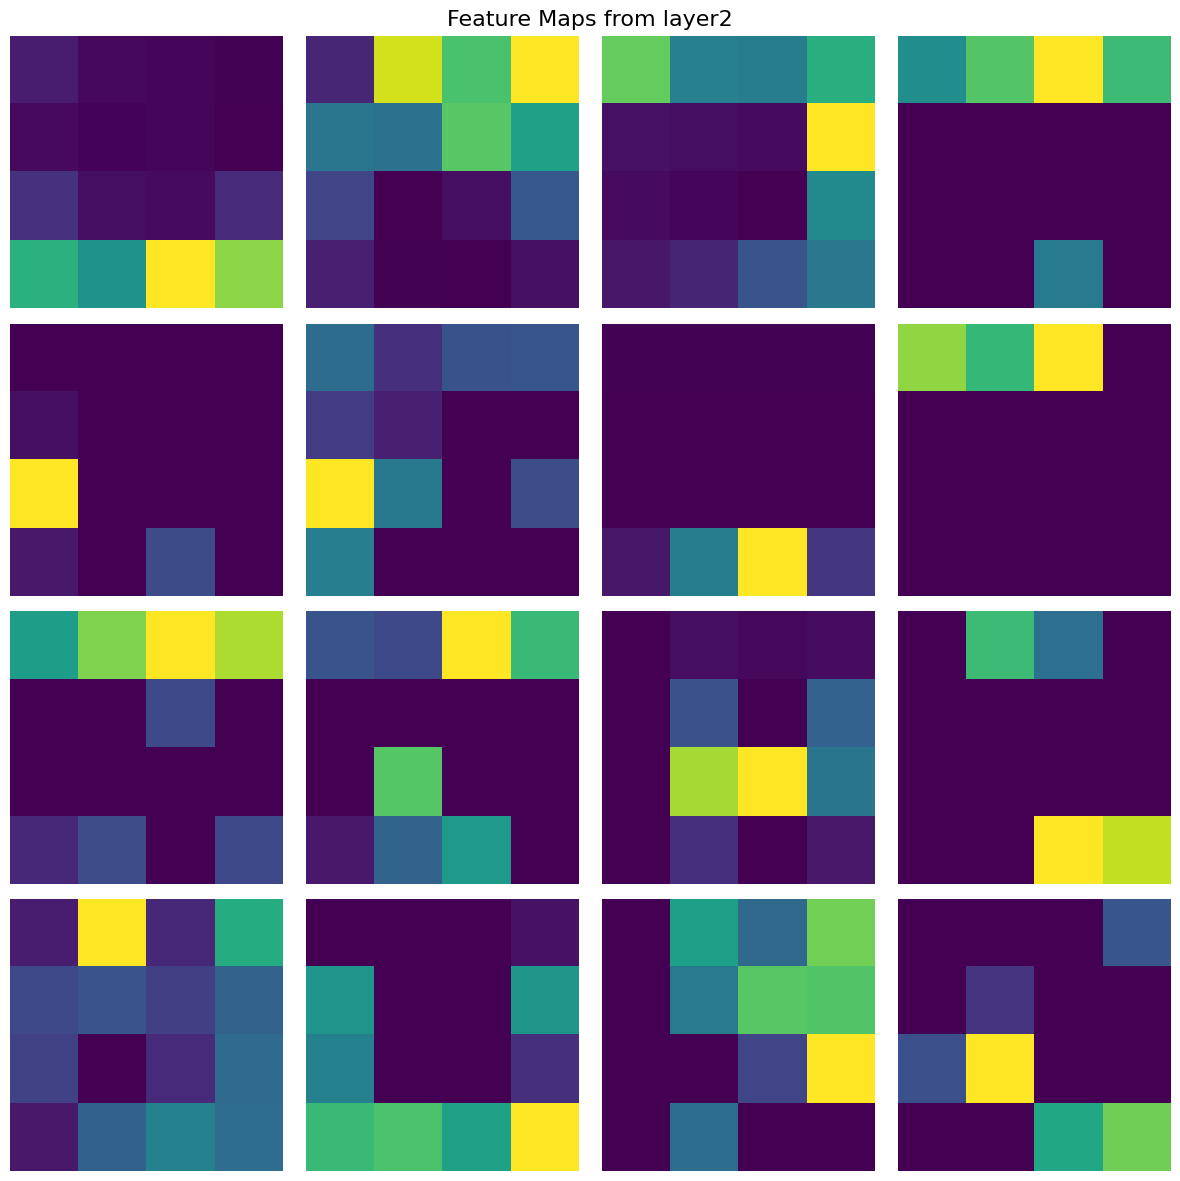

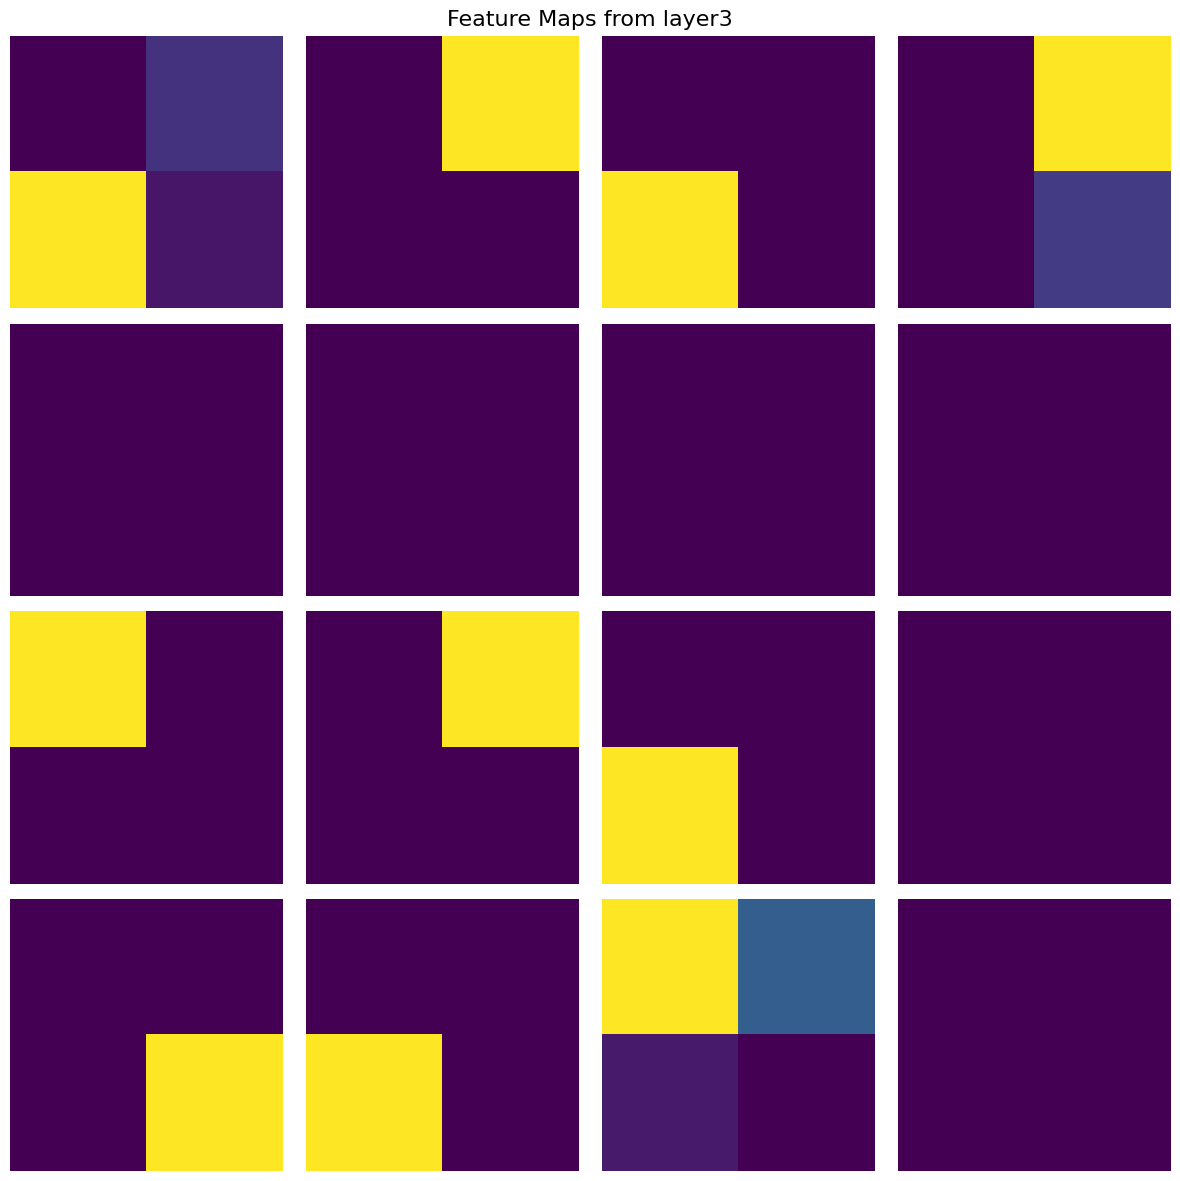

In [6]:
# Select an input image from the dataset
example_image, _ = filtered_dataset[0]  # Replace with your dataset's sample selection

# Specify the layer names you want to visualize (adjust as per your model's structure)
target_layers = ['layer1', 'layer2', 'layer3']  # Replace with actual layer names

# Visualize the feature maps
visualize_feature_maps(model, target_layers, example_image)


**Part 2.**

*Part 2.a*

Using Triplet loss function

In [7]:
# Triplet Loss Class
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        Compute the Triplet Loss: max(0, ||anchor - positive||^2 - ||anchor - negative||^2 + margin)
        """
        positive_distance = torch.nn.functional.pairwise_distance(anchor, positive, p=2)
        negative_distance = torch.nn.functional.pairwise_distance(anchor, negative, p=2)
        loss = torch.clamp(positive_distance - negative_distance + self.margin, min=0.0)
        return loss.mean()


# Feature Extractor (ResNet50 without Fully Connected Layer)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Load pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer

    def forward(self, x):
        """
        Forward pass to extract features.
        """
        features = self.feature_extractor(x)
        return torch.flatten(features, 1)  # Flatten to (batch_size, feature_dim)


# Full Model (Feature Extractor + Classifier)
class FullModel(nn.Module):
    def __init__(self, feature_extractor, num_classes=2):
        super(FullModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc = nn.Linear(2048, num_classes)  # ResNet50 has 2048 feature dimensions

    def forward(self, x):
        features = self.feature_extractor(x)  # Extract features
        outputs = self.fc(features)           # Pass through classifier
        return features, outputs              # Return features and classifier outputs



*Part 2.b-c*



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s] 


Stage 1: Training Feature Extractor with Triplet Loss
Epoch [1/10], Loss: 2.2279
Epoch [2/10], Loss: 1.7363
Epoch [3/10], Loss: 1.7525
Epoch [4/10], Loss: 1.7238
Epoch [5/10], Loss: 1.6404
Epoch [6/10], Loss: 1.8164
Epoch [7/10], Loss: 1.7073
Epoch [8/10], Loss: 1.6734
Epoch [9/10], Loss: 1.6405
Epoch [10/10], Loss: 1.6461


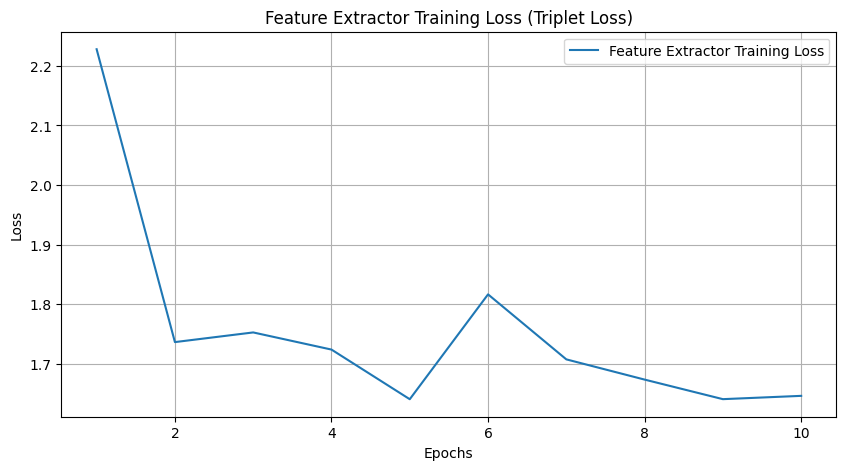


Stage 2: Training Fully Connected Layer with Cross Entropy Loss
Epoch 1/20, Training Loss: 0.3988, Training Accuracy: 81.90%
Validation Loss: 0.3057, Validation Accuracy: 87.90%
Best model updated at epoch 1 with validation accuracy: 87.90%
Epoch 2/20, Training Loss: 0.3127, Training Accuracy: 86.83%
Validation Loss: 0.2730, Validation Accuracy: 88.05%
Best model updated at epoch 2 with validation accuracy: 88.05%
Epoch 3/20, Training Loss: 0.2898, Training Accuracy: 87.99%
Validation Loss: 0.2727, Validation Accuracy: 88.30%
Best model updated at epoch 3 with validation accuracy: 88.30%
Epoch 4/20, Training Loss: 0.2827, Training Accuracy: 88.25%
Validation Loss: 0.2474, Validation Accuracy: 89.55%
Best model updated at epoch 4 with validation accuracy: 89.55%
Epoch 5/20, Training Loss: 0.2645, Training Accuracy: 88.84%
Validation Loss: 0.3109, Validation Accuracy: 86.75%
Epoch 6/20, Training Loss: 0.2548, Training Accuracy: 89.17%
Validation Loss: 0.2464, Validation Accuracy: 89.75%

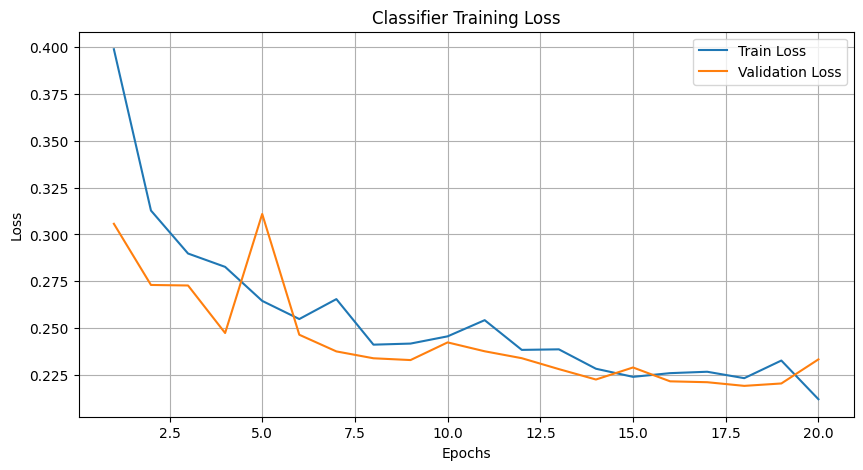

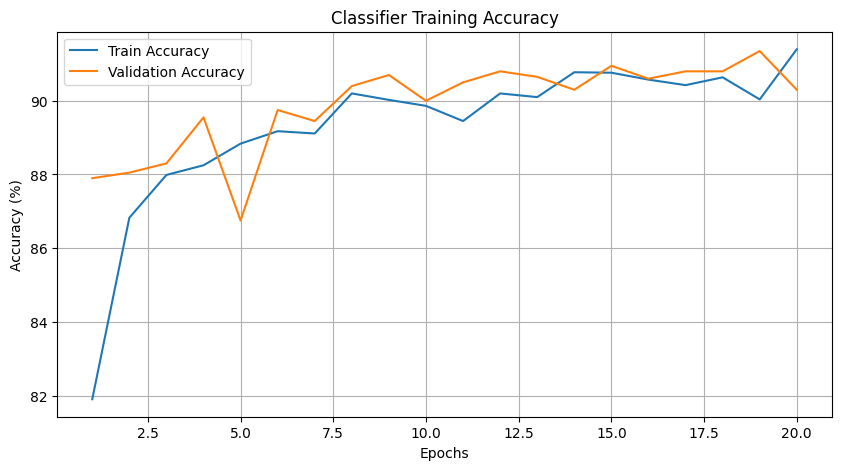


Calculating Final Test Accuracy on Test Dataset...
Test Accuracy: 90.60%
Final Test Accuracy: 90.60%


In [23]:
# Helper function to plot metrics
def plot_loss_accuracy(metrics, title_prefix=""):
    """
    Plots training and validation loss and accuracy.

    Args:
        metrics: Dictionary with 'train_losses', 'train_accuracies', 'val_losses', 'val_accuracies'.
        title_prefix: String to differentiate between Feature Extractor and Classifier plots.
    """
    epochs = len(metrics["train_losses"])

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), metrics["train_losses"], label="Train Loss")
    plt.plot(range(1, epochs + 1), metrics["val_losses"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), metrics["train_accuracies"], label="Train Accuracy")
    plt.plot(range(1, epochs + 1), metrics["val_accuracies"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.grid()
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Stage 1: Training Feature Extractor with Triplet Loss
feature_extractor = FeatureExtractor().to(device)
triplet_loss = TripletLoss(margin=1.0)
optimizer = optim.Adam(feature_extractor.parameters(), lr=1e-4)

print("Stage 1: Training Feature Extractor with Triplet Loss")
train_losses = []

for epoch in range(10):  # Training for 10 epochs
    feature_extractor.train()
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        
        # Generate triplets
        indices = list(range(len(data)))
        random.shuffle(indices)
        anchor = data[indices[:20]]
        positive = data[indices[20:40]]
        negative = data[indices[40:60]]

        optimizer.zero_grad()
        anchor_features = feature_extractor(anchor)
        positive_features = feature_extractor(positive)
        negative_features = feature_extractor(negative)

        loss = triplet_loss(anchor_features, positive_features, negative_features)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}")

# Plot Feature Extractor Loss (No accuracy as triplet loss doesn't provide accuracy)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label="Feature Extractor Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Feature Extractor Training Loss (Triplet Loss)")
plt.legend()
plt.grid()
plt.show()

# Stage 2: Training Fully Connected Classifier with Cross Entropy Loss
print("\nStage 2: Training Fully Connected Layer with Cross Entropy Loss")
for param in feature_extractor.parameters():
    param.requires_grad = False  # Freeze feature extractor

model = FullModel(feature_extractor, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_fc = optim.Adam(model.fc.parameters(), lr=1e-3)

# Train classifier and collect metrics
metrics, trained_model = train(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer_fc, 
    device, 
    epochs=20,  # Training for 20 epochs
    best_model_name="best_classifier_model"
)

# Plot Classifier Training and Validation Metrics
print("\nPlotting Classifier Training and Validation Metrics:")
plot_loss_accuracy(metrics, title_prefix="Classifier Training")

# Final Test Accuracy
print("\nCalculating Final Test Accuracy on Test Dataset...")
test_accuracy = test(trained_model, test_loader, device)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


*Part 2.d*

Visualizing Feature Maps BEFORE Training Feature Extractor:


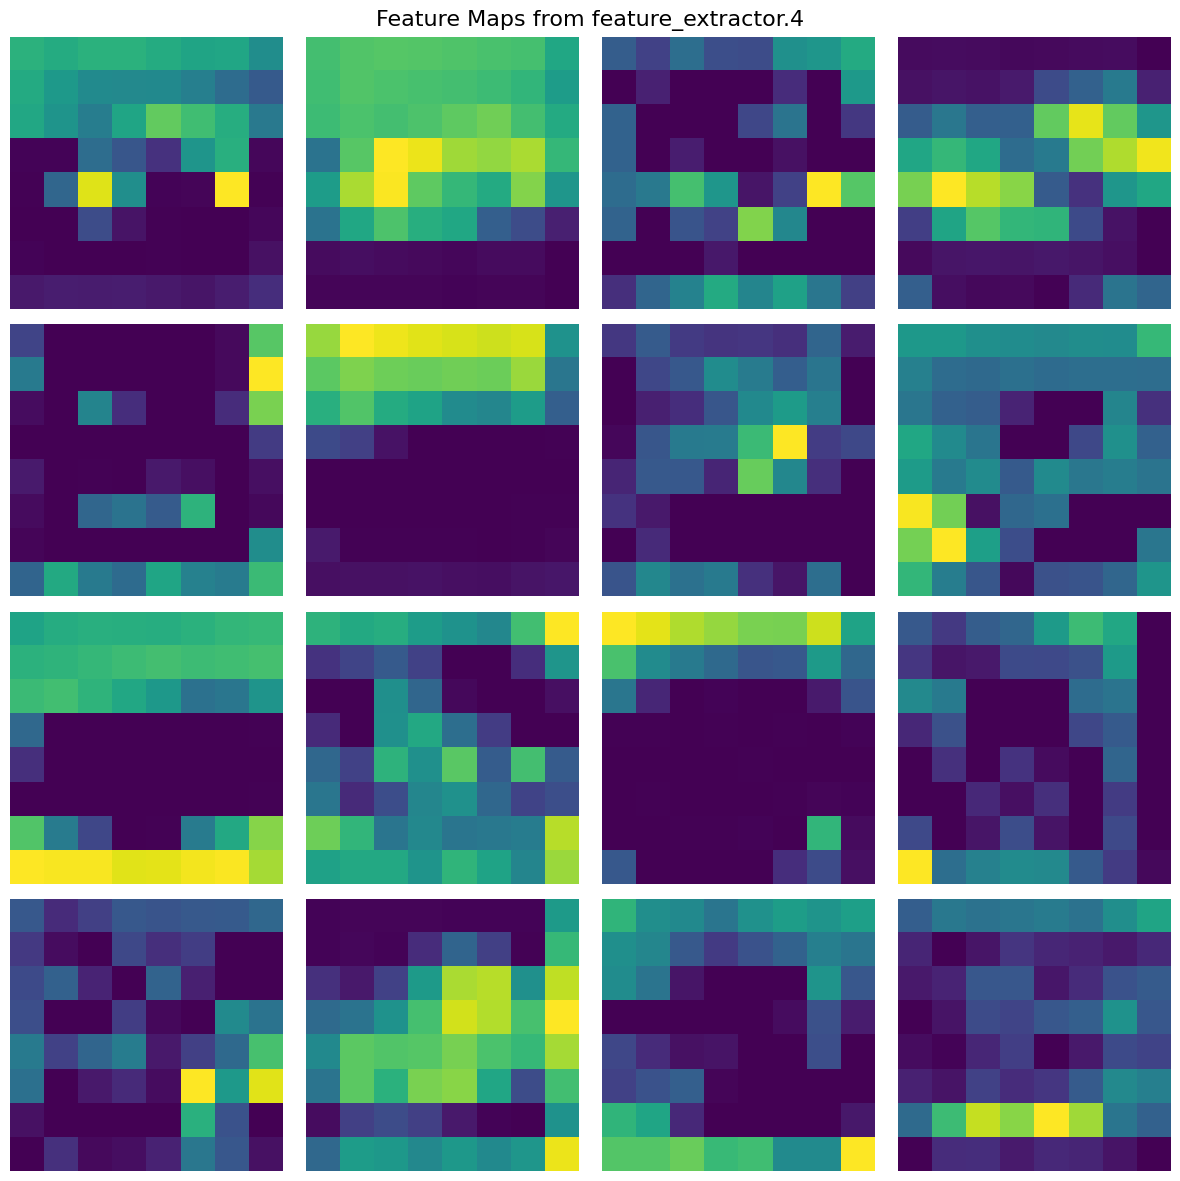

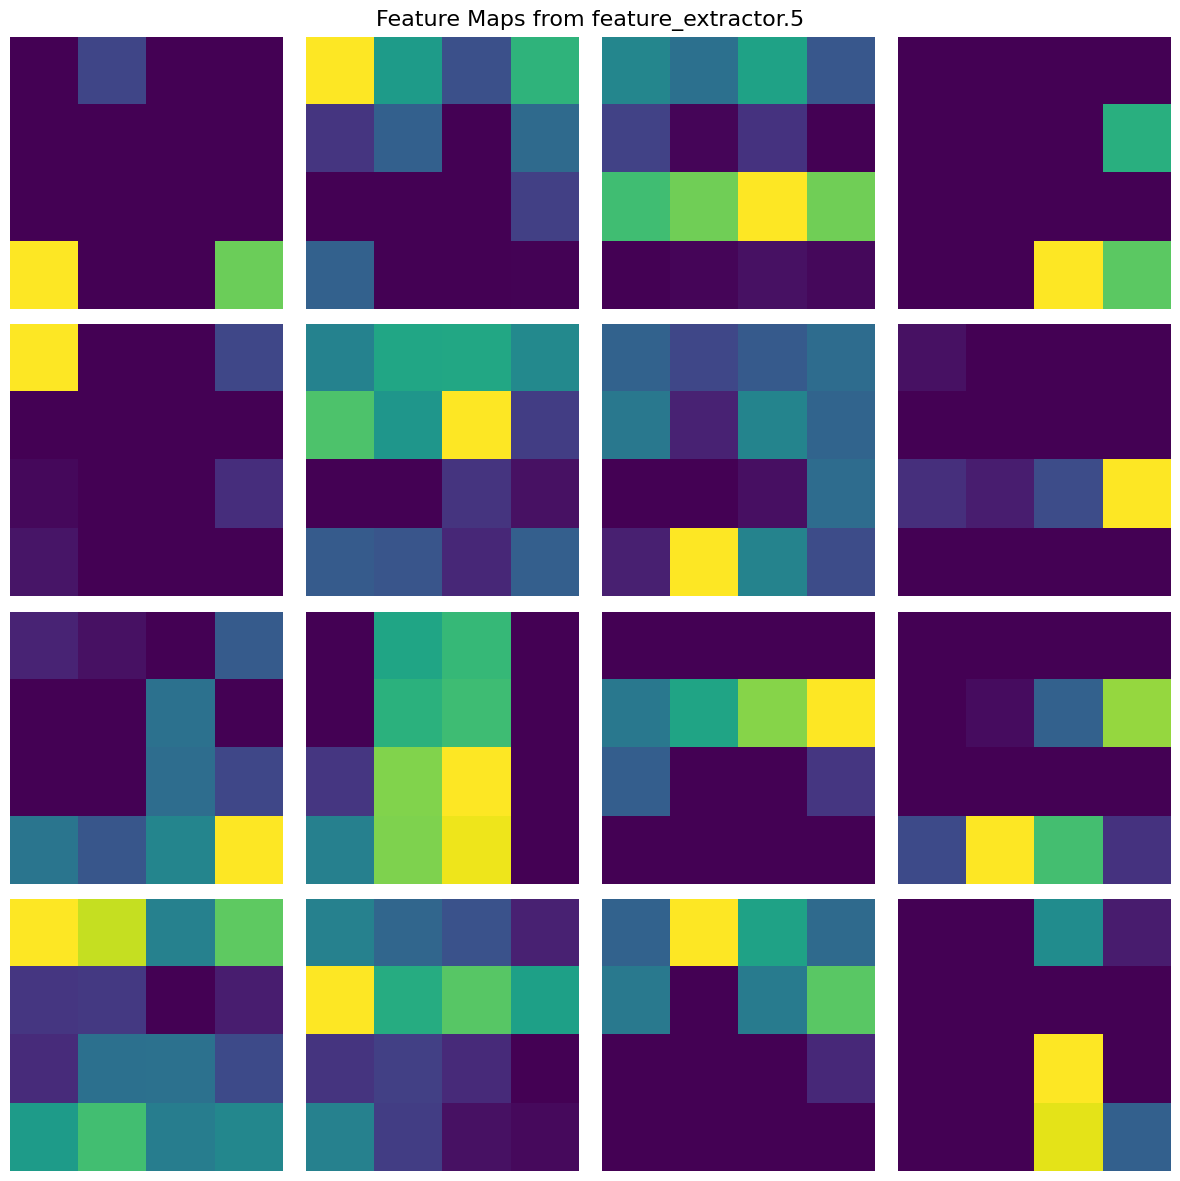

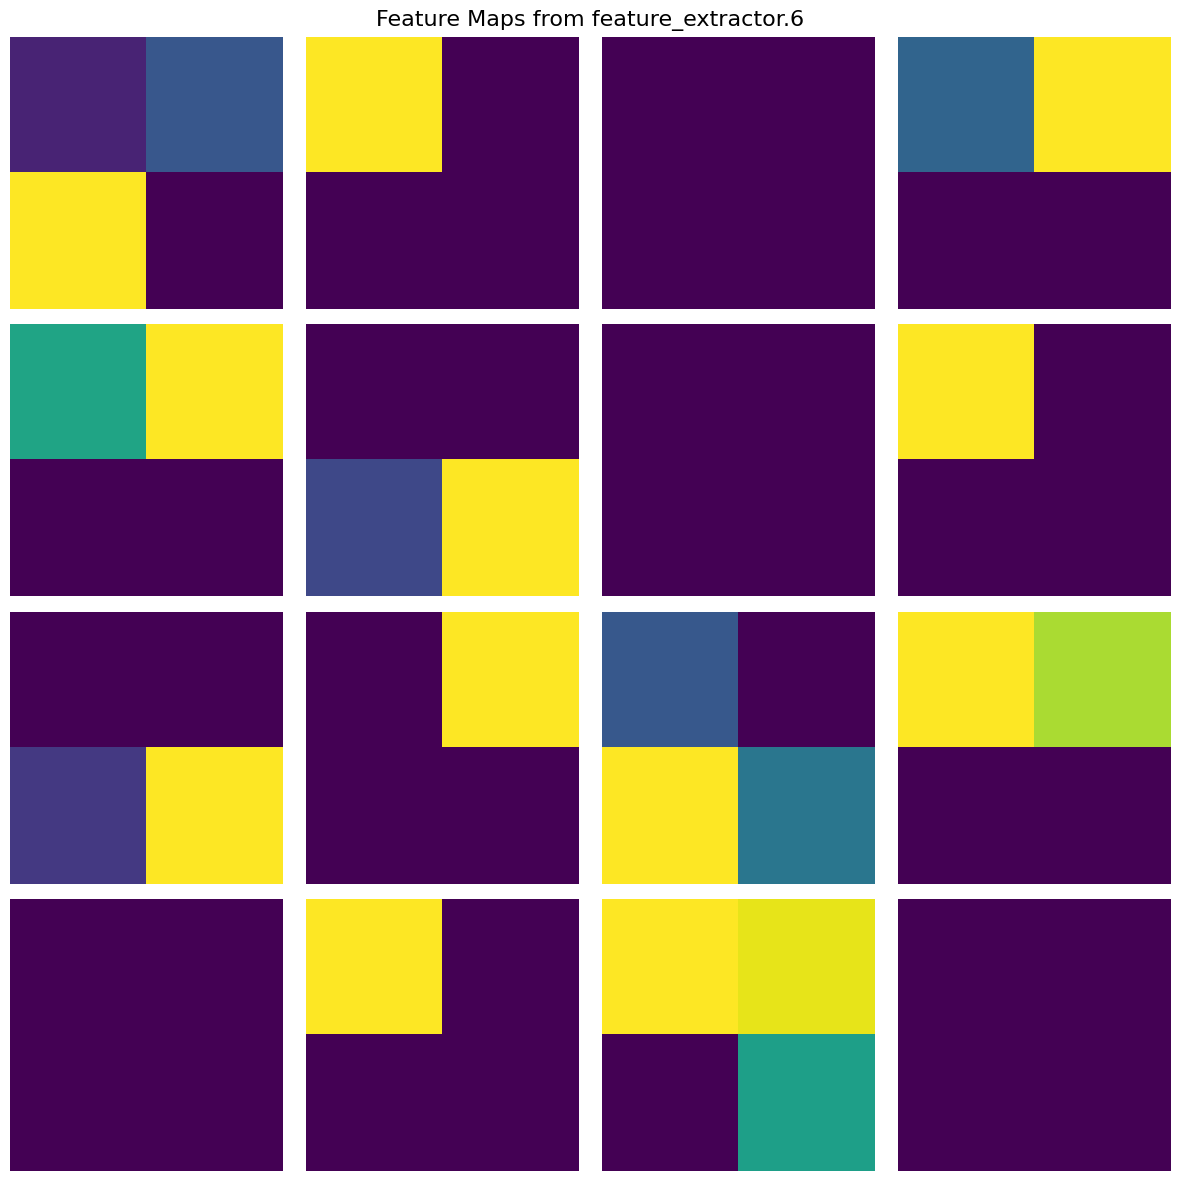

Visualizing Feature Maps AFTER Training Feature Extractor:


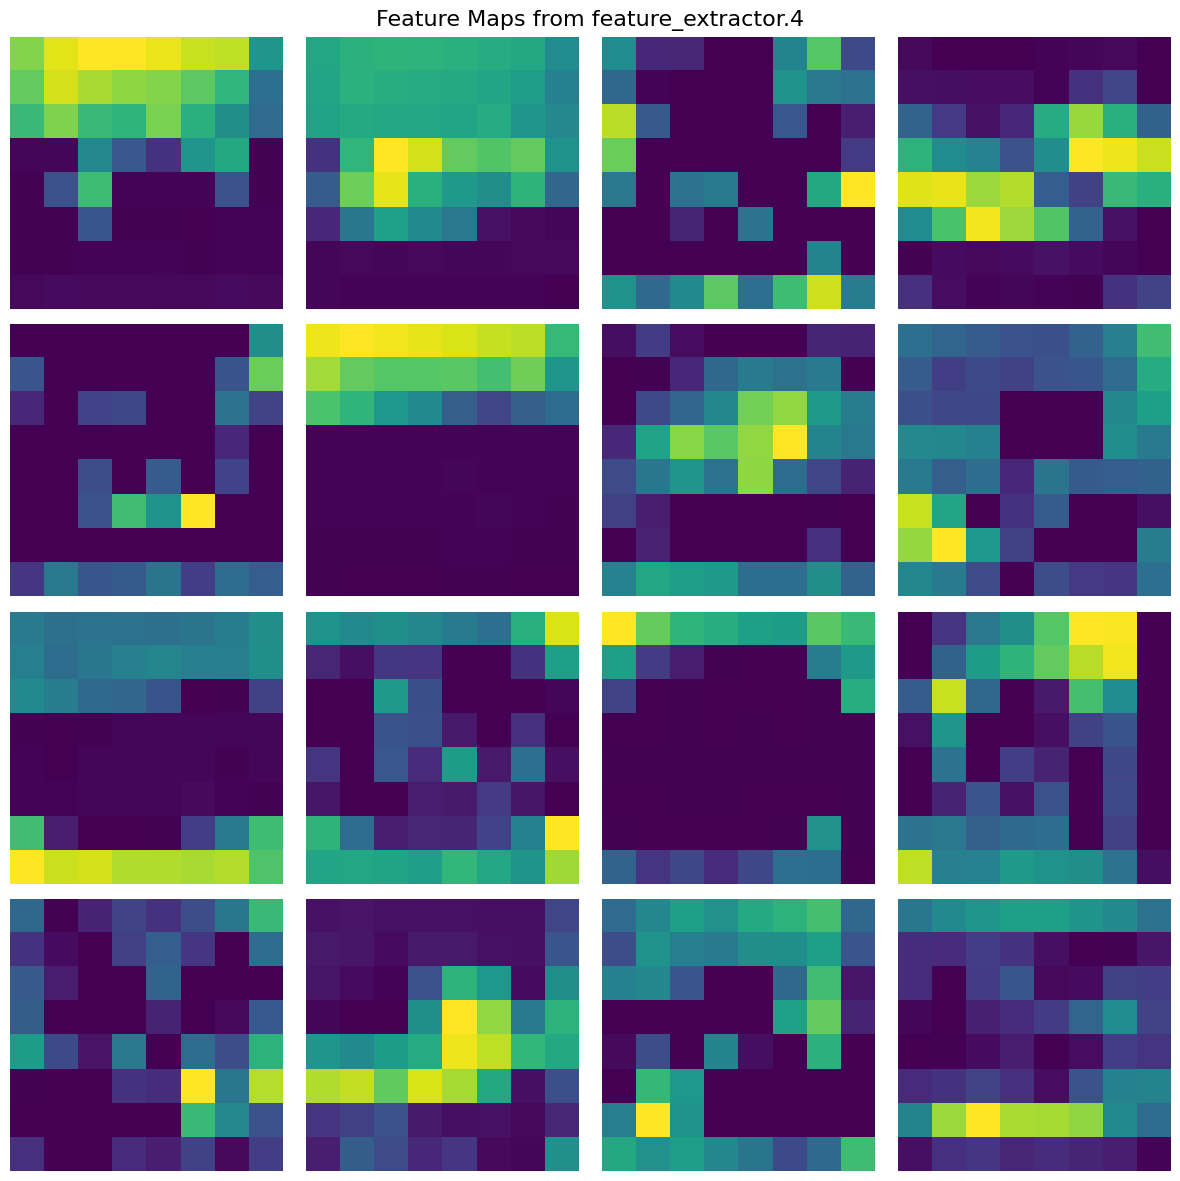

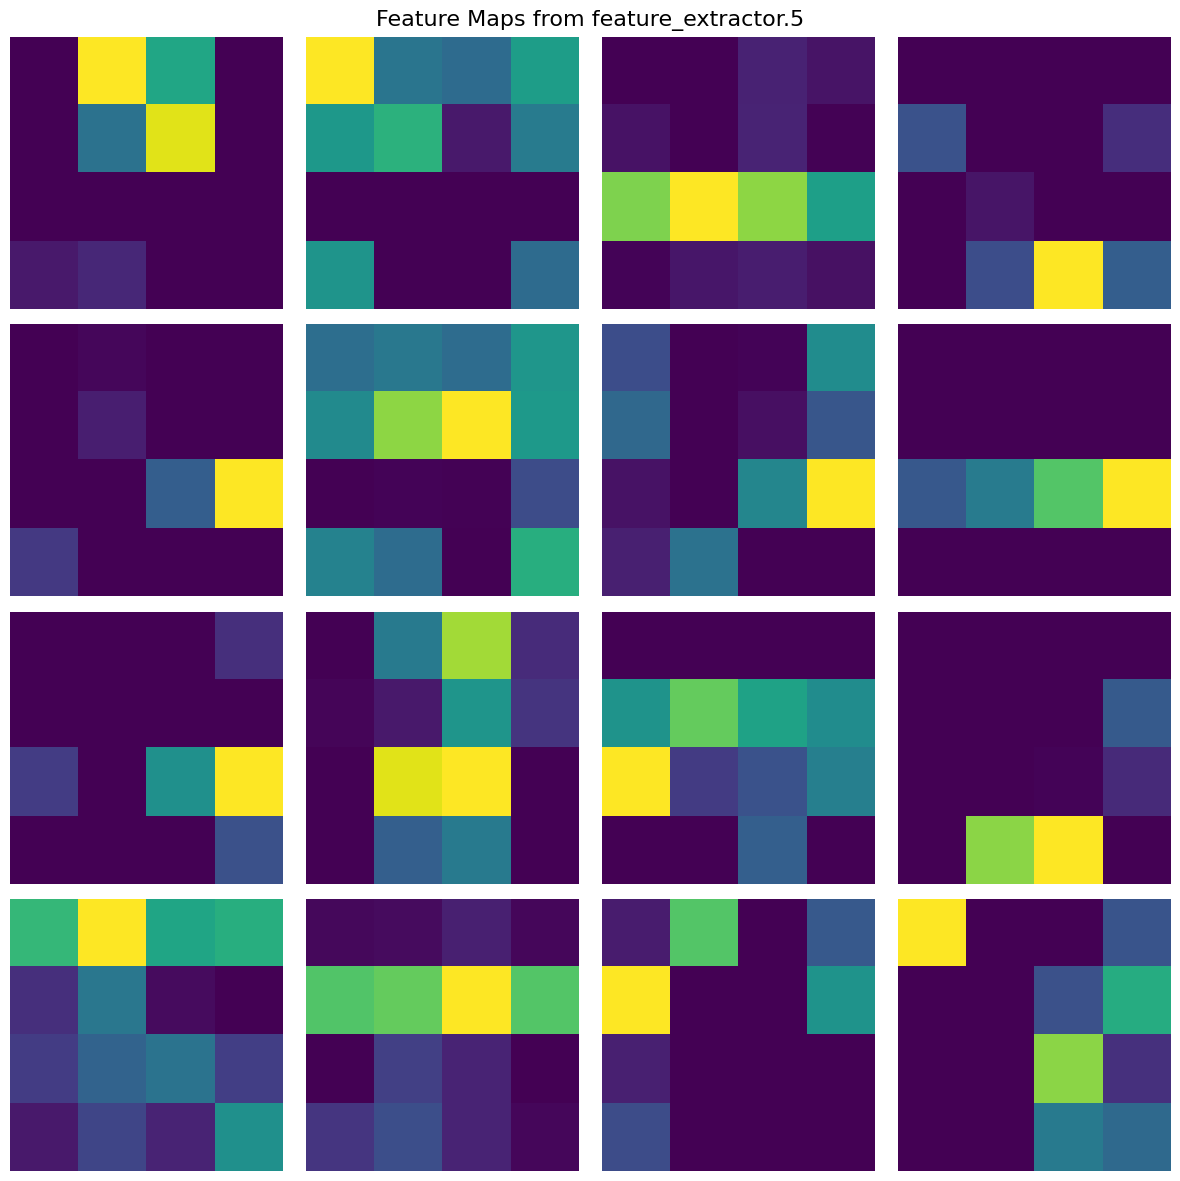

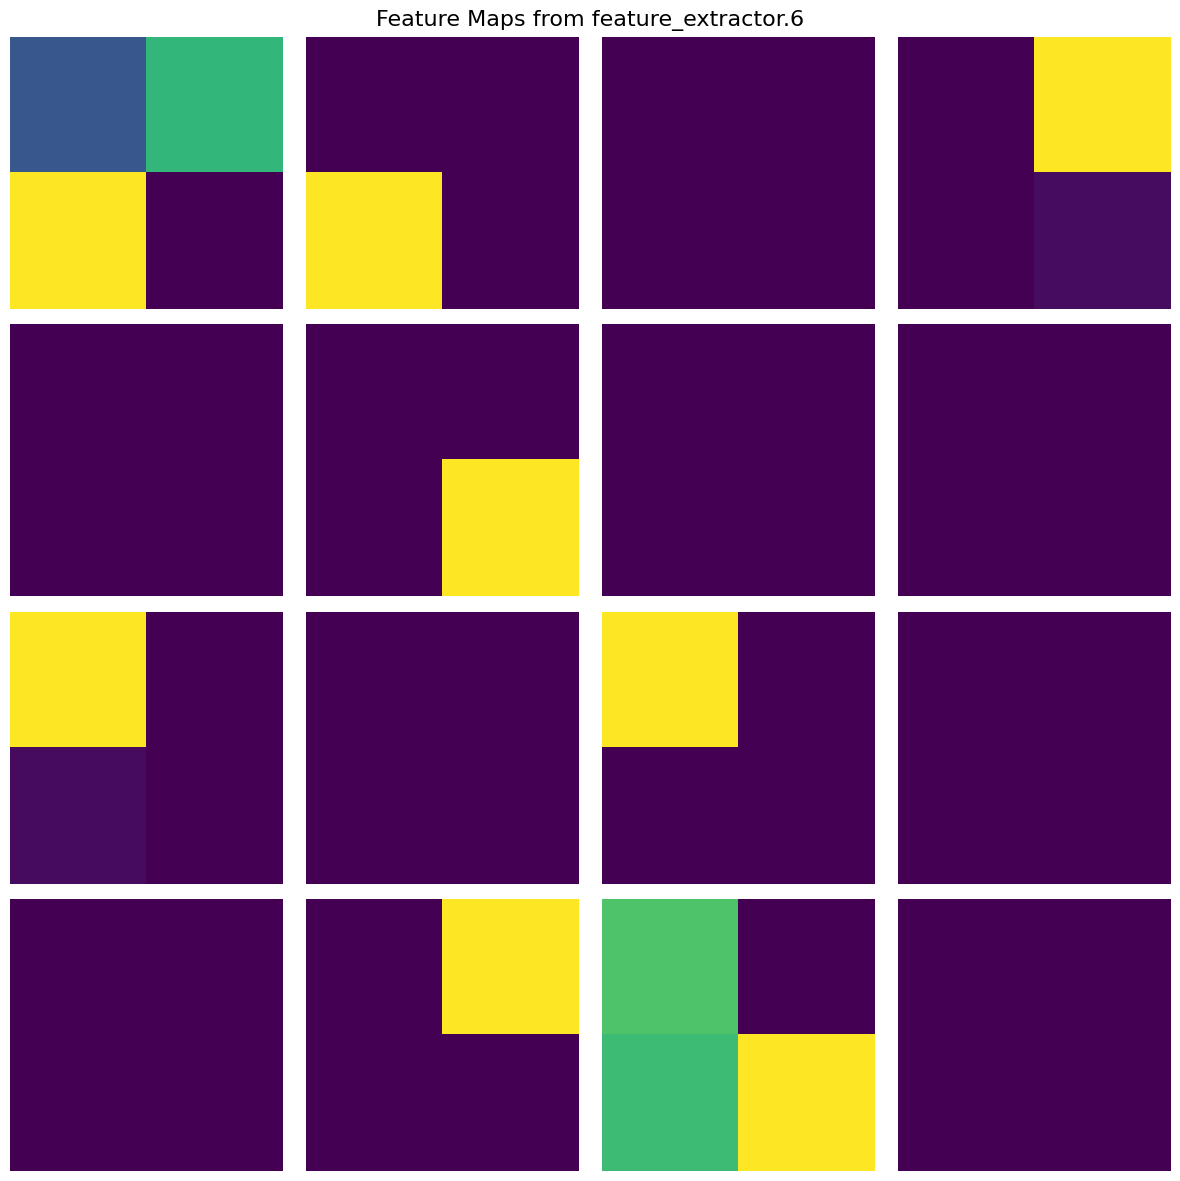

In [24]:
# Specify the layers to visualize feature maps
layer_names = ['feature_extractor.4', 'feature_extractor.5', 'feature_extractor.6']  # Example ResNet layers

# Select an input image from the validation set for visualization
sample_image, _ = next(iter(val_loader))
sample_image = sample_image[0]  # Take the first image from the batch

# Visualize Feature Maps BEFORE Training
print("Visualizing Feature Maps BEFORE Training Feature Extractor:")
untrained_feature_extractor = FeatureExtractor().to(device)
visualize_feature_maps(untrained_feature_extractor, layer_names, sample_image)

# Visualize Feature Maps AFTER Training
print("Visualizing Feature Maps AFTER Training Feature Extractor:")
trained_feature_extractor = feature_extractor  # Feature extractor after Stage 1 training
visualize_feature_maps(trained_feature_extractor, layer_names, sample_image)


**Part 3.**

**Which criterion (loss) is better suited for different use cases?**

*Cross Entropy Loss:*

Best for classification tasks where end-to-end optimization is critical.

Suitable when working with data that is already well-structured and requires high classification accuracy.

*Triplet Loss + CE Loss:*

Best for tasks requiring embedding learning, such as:

Face verification (e.g., distinguishing identities based on similarity).

Retrieval systems (finding similar items in a dataset).

Generalizing to unseen data, as Triplet Loss ensures well-separated embeddings.

Suitable for complex problems where feature extraction needs to generalize across a wide variety of tasks.


**Part 4.**

Combining Triplet Loss and Cross Entropy Loss improves feature learning by balancing embedding optimization and classification performance.

However, it can slightly increase convergence time due to dual objectives.

In [ ]:
# Combined Training Function with tqdm and Metric Printing
def train_combined(model, train_loader, val_loader, triplet_loss_fn, ce_loss_fn, optimizer, device, epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        # Progress bar for training phase
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            # Generate triplets
            indices = list(range(len(images)))
            random.shuffle(indices)
            anchor = images[indices[:20]]
            positive = images[indices[20:40]]
            negative = images[indices[40:60]]

            # Forward pass
            optimizer.zero_grad()
            anchor_features, anchor_outputs = model(anchor)
            positive_features, _ = model(positive)
            negative_features, _ = model(negative)

            # Compute losses
            triplet_loss = triplet_loss_fn(anchor_features, positive_features, negative_features)
            ce_loss = ce_loss_fn(anchor_outputs, labels[:20])
            total_loss = triplet_loss + ce_loss

            # Backpropagation
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            # Compute train accuracy
            _, predicted = torch.max(anchor_outputs, 1)
            correct += (predicted == labels[:20]).sum().item()
            total += labels[:20].size(0)

            train_bar.set_postfix(train_loss=total_loss.item())

        # Calculate average loss and accuracy for training
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        print(f"\nEpoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0

        # Progress bar for validation phase
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                features, outputs = model(images)
                loss = ce_loss_fn(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                val_bar.set_postfix(val_loss=loss.item())

        # Calculate average loss and accuracy for validation
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

        # Save best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    return train_losses, train_accuracies, val_losses, val_accuracies, model

# Plot function
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = len(train_losses)
    
    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Train and Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Main Code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize Model
feature_extractor = FeatureExtractor().to(device)
model = FullModel(feature_extractor, num_classes=2).to(device)
triplet_loss_fn = TripletLoss(margin=1.0)
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train Model
print("Training with Combined Triplet and Cross Entropy Loss...")
train_losses, train_accuracies, val_losses, val_accuracies, best_model = train_combined(
    model, train_loader, val_loader, triplet_loss_fn, ce_loss_fn, optimizer, device, epochs=20
)

# Plot Metrics
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

# Test Accuracy
print("\nTesting the Model...")
test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, download=True, transform=transform),
                         batch_size=64, shuffle=False)
test_accuracy = test(best_model, test_loader, device)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


cuda
Training with Combined Triplet and Cross Entropy Loss...


Epoch 1/20 [Training]: 100%|██████████| 125/125 [00:37<00:00,  3.31it/s, train_loss=2.66]



Epoch [1/20] | Train Loss: 2.9881 | Train Acc: 50.88%


Epoch 1/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 19.06it/s, val_loss=0.764]


Epoch [1/20] | Val Loss: 0.7385 | Val Acc: 51.90%


Epoch 2/20 [Training]: 100%|██████████| 125/125 [00:34<00:00,  3.66it/s, train_loss=3.2] 



Epoch [2/20] | Train Loss: 2.4828 | Train Acc: 48.48%


Epoch 2/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 16.31it/s, val_loss=0.669]


Epoch [2/20] | Val Loss: 0.7141 | Val Acc: 48.55%


Epoch 3/20 [Training]: 100%|██████████| 125/125 [00:39<00:00,  3.15it/s, train_loss=3.02]



Epoch [3/20] | Train Loss: 2.4735 | Train Acc: 49.24%


Epoch 3/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 21.77it/s, val_loss=0.709]


Epoch [3/20] | Val Loss: 0.7277 | Val Acc: 49.10%


Epoch 4/20 [Training]: 100%|██████████| 125/125 [00:25<00:00,  4.91it/s, train_loss=1.38]



Epoch [4/20] | Train Loss: 2.3310 | Train Acc: 52.80%


Epoch 4/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 25.38it/s, val_loss=0.674]


Epoch [4/20] | Val Loss: 0.7155 | Val Acc: 50.35%


Epoch 5/20 [Training]: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s, train_loss=1.44]



Epoch [5/20] | Train Loss: 2.2781 | Train Acc: 49.20%


Epoch 5/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 27.84it/s, val_loss=0.685]


Epoch [5/20] | Val Loss: 0.7141 | Val Acc: 48.70%


Epoch 6/20 [Training]: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s, train_loss=2.22]



Epoch [6/20] | Train Loss: 2.3200 | Train Acc: 49.80%


Epoch 6/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 22.51it/s, val_loss=0.727]


Epoch [6/20] | Val Loss: 0.7069 | Val Acc: 50.40%


Epoch 7/20 [Training]: 100%|██████████| 125/125 [00:26<00:00,  4.78it/s, train_loss=1.91]



Epoch [7/20] | Train Loss: 2.2851 | Train Acc: 48.16%


Epoch 7/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 20.18it/s, val_loss=0.696]


Epoch [7/20] | Val Loss: 0.7078 | Val Acc: 48.75%


Epoch 8/20 [Training]: 100%|██████████| 125/125 [00:29<00:00,  4.27it/s, train_loss=1.08]



Epoch [8/20] | Train Loss: 2.2117 | Train Acc: 49.92%


Epoch 8/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 17.61it/s, val_loss=0.725]


Epoch [8/20] | Val Loss: 0.7199 | Val Acc: 43.90%


Epoch 9/20 [Training]: 100%|██████████| 125/125 [00:27<00:00,  4.58it/s, train_loss=2.58]



Epoch [9/20] | Train Loss: 2.3398 | Train Acc: 48.76%


Epoch 9/20 [Validation]: 100%|██████████| 32/32 [00:01<00:00, 20.46it/s, val_loss=0.741]


Epoch [9/20] | Val Loss: 0.7422 | Val Acc: 39.00%


Epoch 10/20 [Training]: 100%|██████████| 125/125 [00:35<00:00,  3.55it/s, train_loss=2.22]



Epoch [10/20] | Train Loss: 2.4125 | Train Acc: 51.68%


Epoch 10/20 [Validation]: 100%|██████████| 32/32 [00:02<00:00, 14.27it/s, val_loss=0.777]


Epoch [10/20] | Val Loss: 0.7175 | Val Acc: 47.60%


Epoch 11/20 [Training]: 100%|██████████| 125/125 [00:42<00:00,  2.95it/s, train_loss=2.05]



Epoch [11/20] | Train Loss: 2.2747 | Train Acc: 50.08%


Epoch 11/20 [Validation]: 100%|██████████| 32/32 [00:02<00:00, 13.32it/s, val_loss=0.687]


Epoch [11/20] | Val Loss: 0.7273 | Val Acc: 44.45%


Epoch 12/20 [Training]: 100%|██████████| 125/125 [00:43<00:00,  2.84it/s, train_loss=1.79] 



Epoch [12/20] | Train Loss: 2.2573 | Train Acc: 49.28%


Epoch 12/20 [Validation]: 100%|██████████| 32/32 [00:02<00:00, 13.17it/s, val_loss=0.686]


Epoch [12/20] | Val Loss: 0.6825 | Val Acc: 56.05%


Epoch 13/20 [Training]:   9%|▉         | 11/125 [00:05<01:01,  1.86it/s, train_loss=1.2] 